In [1]:
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.model_selection import train_test_split

# Reading Data

In [2]:
def segmentWords(s): 
    return s.split()

def readFile(fileName):
    # Function for reading file
    # input: filename as string
    # output: contents of file as list containing single words
    contents = []
    f = open(fileName)
    for line in f:
        contents.append(line)
    f.close()
    result = segmentWords('\n'.join(contents))
    return result

#### Create a Dataframe containing the counts of each word in a file

In [3]:
d = []

for c in os.listdir("data_training"):
    directory = "data_training/" + c
    for file in os.listdir(directory):
        words = readFile(directory + "/" + file)
        e = {x:words.count(x) for x in words}
        e['__FileID__'] = str(file)
        e['__CLASS__'] = str(c)
        d.append(e)

Create a dataframe from d - make sure to fill all the nan values with zeros.

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html


In [4]:
df = pd.DataFrame(d)
df = df.fillna(0)

#### Split data into training and validation set 

* Sample 80% of your dataframe to be the training data

* Let the remaining 20% be the validation data (you can filter out the indicies of the original dataframe that weren't selected for the training data)

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html

In [5]:
#from sklearn.model_selection import train_test_split
#train, valid = train_test_split(df, test_size=0.2)

train = df.sample(frac=0.8)
valid = df.drop(train.index)

* Split the dataframe for both training and validation data into x and y dataframes - where y contains the labels and x contains the words

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html

In [94]:
y_train = train['__CLASS__']
x_train = train.drop('__CLASS__', axis=1)
x_train = x_train.drop('__FileID__', axis=1)

y_valid = valid['__CLASS__']
x_valid = valid.drop('__CLASS__', axis=1)
x_valid = x_valid.drop('__FileID__', axis=1)

# Logistic Regression

#### Basic Logistic Regression
* Use sklearn's linear_model.LogisticRegression() to create your model.
* Fit the data and labels with your model.
* Score your model with the same data and labels.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

#fitting model to training set
#clearly overfitting since accuracy is 100%
model = LogisticRegression()
model = model.fit(x_train, y_train)
model.score(x_train, y_train)

1.0

In [45]:
#testing on validation set
model.score(x_valid, y_valid)

0.84567901234567899

#### Changing Parameters

In [82]:
model = LogisticRegression(C=.008)
model = model.fit(x_train, y_train)
model.score(x_train, y_train)

0.98688271604938271

In [47]:
model.score(x_valid, y_valid)

0.83950617283950613

#### Feature Selection
* In the backward stepsize selection method, you can remove coefficients and the corresponding x columns, where the coefficient is more than a particular amount away from the mean - you can choose how far from the mean is reasonable.

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html#
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.where.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.std.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.mean.html

In [83]:
mean = model.coef_[0].mean()
std = model.coef_[0].std()
arr = model.coef_[0].copy()

In [78]:
#using backward stepsize selection
col = []
for i in range(len(model.coef_[0])):
    if model.coef_[0][i] < mean - std/3 or mean + std/3 < model.coef_[0][i]:
        col.append(i)
        
new_x_train = x_train.copy()
new_x_valid = x_valid.copy()

drop = [x_train.columns[i] for i in col]
new_x_train.drop(drop, axis=1, inplace=True)
new_x_valid.drop(drop, axis=1, inplace=True)

model = LogisticRegression(C=.01, tol=2)
model = model.fit(new_x_train, y_train)

#reduces overfitting
print(model.score(new_x_train, y_train))
print(model.score(new_x_valid, y_valid))

0.956790123457
0.83024691358


How did you select which features to remove? Why did that reduce overfitting?

I selected the features to remove by looking at the coefficients of the model, or weights, and removing the columns of our dataframe which corresponded to weights that were more than 1/3 of the standard deviation away from the mean of the weights of the model. This reduced overfitting because it removed data which was far away from the mean, meaning that the model could no longer fit to certain outliers in the data anymore. 

In [84]:
#other attempts at reducing overfitting

#setting weights to 0 if determined to be far enough from the mean
model = LogisticRegression(C=.01, tol=2)
model = model.fit(x_train, y_train)

for i in range(model.coef_[0].shape[0]):
    diff = abs(model.coef_[0][i]-mean)

    if diff > std/10:
        model.coef_[0][i] = 0

print(model.score(x_train, y_train))
print(model.score(x_valid, y_valid))

0.503086419753
0.487654320988


In [86]:
#adjusting hyperparameters
model = LogisticRegression(penalty='l1', C=.01, tol=2)
model = model.fit(x_train, y_train)

print(model.score(x_train, y_train))
print(model.score(x_valid, y_valid))

1.0
0.577160493827


In [87]:
#using RFE
from sklearn.feature_selection import RFE
rfe = RFE(model, 10000, 1000)
rfe = rfe.fit(x_train, y_train)

print(rfe.score(x_train, y_train))
print(rfe.score(x_valid, y_valid))

1.0
0.66975308642


In [88]:
#using RFECV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=model, step=1000, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(x_train, y_train)

print(rfecv.score(x_train, y_train))
print(rfecv.score(x_valid, y_valid))

1.0
0.648148148148


# Single Decision Tree

#### Basic Decision Tree

* Initialize your model as a decision tree with sklearn.
* Fit the data and labels to the model.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


In [8]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

In [9]:
def score_sets(clf, x_train, y_train, x_valid, y_valid):
    print("Training Score is: " + str(clf.score(x_train, y_train)))
    print("Validation Score is: " + str(clf.score(x_valid, y_valid)))
    return (clf.score(x_train, y_train) , clf.score(x_valid, y_valid))

In [10]:
score_sets(clf, x_train, y_train, x_valid, y_valid)

Training Score is: 1.0
Validation Score is: 0.651234567901


(1.0, 0.65123456790123457)

Yes I am definitely overfitting

#### Changing Parameters
* To test out which value is optimal for a particular parameter, you can either loop through various values or look into sklearn.model_selection.GridSearchCV

References:


http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [11]:
clf_log = tree.DecisionTreeClassifier(max_features = "log2")
clf_log = clf_log.fit(x_train, y_train)
log_dttr, log_dtv = score_sets(clf_log, x_train, y_train, x_valid, y_valid)

Training Score is: 1.0
Validation Score is: 0.537037037037


In [12]:
clf_sqrt = tree.DecisionTreeClassifier(max_features = "sqrt")
clf_sqrt = clf_sqrt.fit(x_train, y_train)
sqrt_dttr, sqrt_dtv = score_sets(clf_sqrt, x_train, y_train, x_valid, y_valid)

Training Score is: 1.0
Validation Score is: 0.561728395062


In [13]:
clf_auto = tree.DecisionTreeClassifier(max_features = "auto")
clf_auto = clf_auto.fit(x_train, y_train)
auto_dttr, auto_dtv = score_sets(clf_auto, x_train, y_train, x_valid, y_valid)

Training Score is: 1.0
Validation Score is: 0.543209876543


In [19]:
from operator import itemgetter
def report(grid_scores):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:3]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0}".format(score.mean_validation_score))
        print("Parameters: {0}".format(score.parameters))
        print("")
    return (top_scores[0].parameters, top_scores[1].parameters, top_scores[2].parameters)

In [20]:
from sklearn.grid_search import GridSearchCV
def run_gridsearch(X, y, clf, param_grid, cv=3):
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=cv)
    grid_search.fit(X, y)
    top_params = report(grid_search.grid_scores_)
    return  top_params

In [21]:
param_grid = {"criterion": ["gini", "entropy"],
              "max_features": ["auto", "log2"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],}
clf = tree.DecisionTreeClassifier()
best_parameters, sec_best_parameters, third_best_parameters = run_gridsearch(x_train, y_train, clf, param_grid)

Model with rank: 1
Mean validation score: 0.6134259259259259
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.6057098765432098
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.6018518518518519
Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 20}



In [24]:
best_parameters

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10}

In [25]:
sec_best_parameters

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10}

In [27]:
third_best_parameters

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 20}

In [29]:
#first best parameters
clf_best = tree.DecisionTreeClassifier(criterion= 'entropy',
 max_depth= None,
 max_features= 'auto',
 min_samples_leaf= 1,
 min_samples_split= 10)
clf_best = clf_best.fit(x_train, y_train)
best_dttr, best_dtv = score_sets(clf_best, x_train, y_train, x_valid, y_valid)

Training Score is: 0.941358024691
Validation Score is: 0.58950617284


In [32]:
#second best parameters
clf_sec_best = tree.DecisionTreeClassifier(criterion= 'entropy',
 max_depth= 10,
 max_features= 'auto',
 min_samples_leaf= 10,
 min_samples_split= 10)
clf_sec_best = clf_sec_best.fit(x_train, y_train)
sec_best_dttr, sec_best_dtv = score_sets(clf_sec_best, x_train, y_train, x_valid, y_valid)

Training Score is: 0.611882716049
Validation Score is: 0.515432098765


In [33]:
clf_thr_best = tree.DecisionTreeClassifier(criterion= 'entropy',
 max_depth= 10,
 max_features= 'auto',
 min_samples_leaf= 1,
 min_samples_split= 20)
clf_thr_best = clf_thr_best.fit(x_train, y_train)
thr_best_dttr, thr_best_dtv = score_sets(clf_thr_best, x_train, y_train, x_valid, y_valid)

Training Score is: 0.627314814815
Validation Score is: 0.558641975309


What corrects the overfitting in these examples is the explicit definition of max_depth and min_smaples_leaf. Max_depth essentially limits how deep the decision tree can be and thus limit the complexity of the decision boundaries on the training data so as not to overfit. Min_smaples_leaf specifically changes the model's sensitivity to noise in the training data where a smaller number of sample leaves makes the model more prone to capturing noise.

How did you choose which parameters to change and what value to give to them? Feel free to show a plot.

Although I chose the parameters the way I did because of grid search telling me that those were the best combinations, I honestly don't believe those were the ideal combinations simply because I realized that a simple decision tree with default parameters usually preforms just as well on the validation set as a "optimized" decision tree with grid search. This is evident by the graph below this.

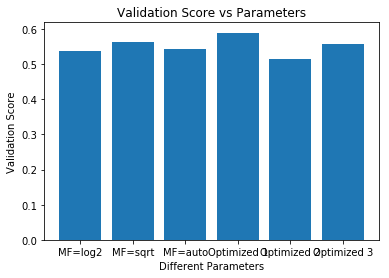

In [34]:
import matplotlib.pyplot as plt
x = np.arange(6)
validation_scores = [log_dtv, sqrt_dtv, auto_dtv, best_dtv, sec_best_dtv, thr_best_dtv]
fig, ax = plt.subplots()
ax.set_ylabel('Validation Score')
ax.set_xlabel('Different Parameters')
ax.set_title('Validation Score vs Parameters')
plt.bar(x, validation_scores)
plt.xticks(x, ('MF=log2', 'MF=sqrt', 'MF=auto', 'Optimized 1', "Optimized 2", "Optimized 3"))
plt.show()

Why is a single decision tree so prone to overfitting?

As we increase the depth of the decision tree, we increase the complexity of the decision boundaries and what this ends up doing is it draws decision boundaries that are overfitted to the training data. The following graph below all the trials that change max_depth depict this phenomenon. It is worth mentioning that the default max_depth = None.

In [35]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth = 1)
clf = clf.fit(x_train, y_train)
md1_dttr, md1_dtv = score_sets(clf, x_train, y_train, x_valid, y_valid)

Training Score is: 0.618055555556
Validation Score is: 0.645061728395


In [36]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth = 2)
clf = clf.fit(x_train, y_train)
md2_dttr, md2_dtv = score_sets(clf, x_train, y_train, x_valid, y_valid)

Training Score is: 0.641975308642
Validation Score is: 0.694444444444


In [37]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth = 5)
clf = clf.fit(x_train, y_train)
md5_dttr, md5_dtv = score_sets(clf, x_train, y_train, x_valid, y_valid)

Training Score is: 0.744598765432
Validation Score is: 0.682098765432


In [38]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth = 20)
clf = clf.fit(x_train, y_train)
md20_dttr, md20_dtv = score_sets(clf, x_train, y_train, x_valid, y_valid)

Training Score is: 0.986882716049
Validation Score is: 0.66049382716


In [39]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth = 100)
clf = clf.fit(x_train, y_train)
md100_dttr, md100_dtv = score_sets(clf, x_train, y_train, x_valid, y_valid)

Training Score is: 1.0
Validation Score is: 0.654320987654


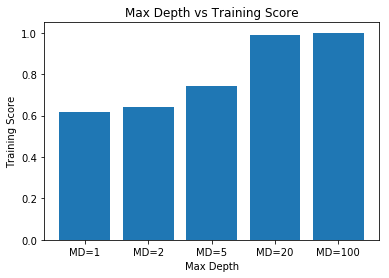

In [40]:
import matplotlib.pyplot as plt
x = np.arange(5)
validation_scores = [md1_dttr, md2_dttr, md5_dttr, md20_dttr, md100_dttr]
fig, ax = plt.subplots()
ax.set_ylabel('Training Score')
ax.set_xlabel('Max Depth')
ax.set_title('Max Depth vs Training Score')
plt.bar(x, validation_scores)
plt.xticks(x, ('MD=1', 'MD=2', 'MD=5', 'MD=20', "MD=100"))
plt.show()

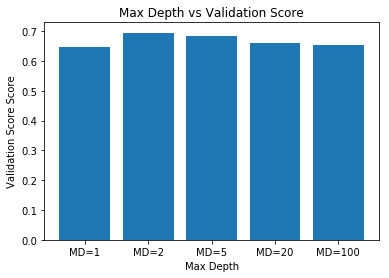

In [41]:
import matplotlib.pyplot as plt
x = np.arange(5)
validation_scores = [md1_dtv, md2_dtv, md5_dtv, md20_dtv, md100_dtv]
fig, ax = plt.subplots()
ax.set_ylabel('Validation Score Score')
ax.set_xlabel('Max Depth')
ax.set_title('Max Depth vs Validation Score')
plt.bar(x, validation_scores)
plt.xticks(x, ('MD=1', 'MD=2', 'MD=5', 'MD=20', "MD=100"))
plt.show()

# Random Forest Classifier

#### Basic Random Forest

* Use sklearn's ensemble.RandomForestClassifier() to create your model.
* Fit the data and labels with your model.
* Score your model with the same data and labels.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


In [42]:
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier()
rfclf = rfclf.fit(x_train, y_train)
score_sets(rfclf, x_train, y_train, x_valid, y_valid)

Training Score is: 0.993055555556
Validation Score is: 0.675925925926


(0.99305555555555558, 0.67592592592592593)

#### Changing Parameters

In [43]:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_features": ["auto", "log2"],  
              "max_depth": [None, 5, 20, 100],}
rfclf = RandomForestClassifier()
best_parameters = run_gridsearch(x_train, y_train, rfclf, param_grid)

Model with rank: 1
Mean validation score: 0.7986111111111112
Parameters: {'max_depth': 100, 'max_features': 'auto', 'n_estimators': 1000}

Model with rank: 2
Mean validation score: 0.7939814814814815
Parameters: {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 1000}

Model with rank: 3
Mean validation score: 0.7924382716049383
Parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 1000}



In [93]:
rfclf_best = RandomForestClassifier(max_depth=100, max_features='auto', n_estimators=1000)
rfclf_best = rfclf_best.fit(x_train, y_train)
score_sets(rfclf_best, x_train, y_train, x_valid, y_valid)

Training Score is: 1.0
Validation Score is: 0.820987654321


(1.0, 0.82098765432098764)

What parameters did you choose to change and why?

I chose to run grid search on three parameters, one specific to random forest, and the other two generalized to the decision trees in random forests. One of my parameters was necessarily the number of decision trees I include in my random forest, where most often a greater number of decision trees will result in a more accurate classifier against the validation set. The other parameters I chose to check were max_depth because it had a very relevant impact on not overfitting the training data, and max_features which is data specific but generally increases the options to be considered at every node. However, a lot of overfitting is taken care of by the nature of a random forest as explained below. The parameters I did not include in the grid search were ommited because they were computationally expensive and they were also pretty trivial. 

How does a random forest classifier prevent overfitting better than a single decision tree?

A random forest essentially takes a random fraction of the data and selects only a random fraction of features and builds many decision trees on these different random subsets. What this ends up doing is creating many trees that are of a shallower depth (low overfit) and averaging the results of these trees. It isn't as prone to overfitting as analyzing all features in one decision tree and creating a really complex decision boundary because of its large depth.